In [210]:
import pandas as pd
import numpy as np
import os
import getpass
import random
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [106]:
def list_files(files):
    """Accepts a list and returns a dictionary of each item in list with a numbered index (key) starting at 1"""

    dir_list = {0:'Exit'}
    file_count = 0
    for file in files:
        file_count +=1
        dir_list[file_count] = file  # assign a number to each item in the list starting with 1 
    return dir_list  # returns the dictionary of items in the list

def print_dict(dict_items):
    """Prints the key:value pairing in a dictionary"""

    for key, value in dict_items.items():
        print(key, ":", value)

def check_dict(dict_to_check, choice):
    """Checks if the input choice is a key in the provided dictionary
        and returns 'valid' if true, 'invalid' if false"""

    if choice in dict_to_check:
        key_exists = "valid"
    else:
        key_exists = "invalid"

    return key_exists

def error_message(invalid_choice):
    print(f"Your input of '{invalid_choice}' is not a valid choice.")

def validate_int(user_input):
    """Checks if user input is an int. If not returns 'is_not_int'"""

    try:
        int(user_choice)
    except ValueError:
        print(f"'{user_choice}' is not an integer.")
        return "is_not_int"

def file_message():
    message1 = {1:'Great choice', 2:'Yes', 3:'Right away', 4:'Beep Boop Boop'}
    message2 = {1:'Fetching', 2:'Opening', 3:'Gathering'}

    mess1 = message1[random.randint(1,4)]
    mess2 = message2[random.randint(1,3)]
    return (mess1,mess2)

def determine_ulimit_position(top_position):
    if top_position == "Upper Limit":
        return 0
    else:
        return 1

def target_test_keys(keys): 
    """Accepts a list of lists and returns a list of the first value from each list"""
    
    spec_keys = []
    for i in range(len(keys)):
        spec_keys.append(keys[i][0])
    return spec_keys

def get_target_columns(col_list, spec_keys):
    target_columns = []
    for i in range(len(col_list)):
        if col_list[i] in spec_keys:
            target_columns.append(col_list[i])
    return target_columns

def create_spec_dict(spec_arr):
    new_dict = {}
    new_list = []
    for i in range(len(spec_arr)):
        new_list = [spec_arr[i][1],spec_arr[i][2]]
        new_dict[spec_arr[i][0]] = new_list
    return new_dict

def combine_limits(targ_col,prod_spec_dict):  # This is making a big assumption that the lower limits are listed before upper limits in specifications file
    prod_ll = []
    prod_ul = []
    prod_ll_dict = {}
    prod_ul_dict = {}
    for i in range(len(targ_col)):
        key = targ_col[i]
        prod_ll.append(prod_spec_dict[key][0])
        prod_ul.append(prod_spec_dict[key][1])
        
    prod_ll_dict['lower_limits'] = prod_ll
    prod_ul_dict['upper_limits'] = prod_ul
    return {**prod_ll_dict, **prod_ul_dict}

In [ ]:
dirs = sorted(os.listdir('data'))
dir_list = list_files(dirs)  # returned dict of files in directory

print_dict(dir_list)
user_choice = input('Enter the number next to the file to open. (0 to exit): ')

int_check = validate_int(user_choice)
if int_check == "is_not_int":
    validate_choice = "invalid"
else:
    validate_choice = check_dict(dir_list, int(user_choice)) # check to see if user input is a key in the dictionary

while validate_choice == "invalid":
    error_message(user_choice)
    print_dict(dir_list)
    user_choice = input('Enter the number next to the file to open. (0 to exit): ')
    int_check = validate_int(user_choice)
    if int_check == "is_not_int":
        validate_choice = "invalid"
    else:
        validate_choice = check_dict(dir_list, int(user_choice)) # check to see if user input is a key in the dictionary

    if user_choice == 0:
        break
    

print(f"{user_choice} is a valid choice")

print(dir_list[int(user_choice)])

if int(user_choice) != 0:
    file_to_open = 'data/' + dir_list[int(user_choice)]
    df = pd.read_csv(file_to_open)


In [207]:
# Super easy no error path

dirs = sorted(os.listdir('data'))
dir_list = list_files(dirs)  # returned dict of files in directory

user_choice = 3

if int(user_choice) != 0:
    selected_file = dir_list[int(user_choice)]
    fill_messages = file_message()
    print(f"{fill_messages[0]}! {fill_messages[1]} {selected_file} now...")
    time.sleep(2)  # pause execution for message
    df_all_specs = pd.read_csv('specifications.csv').set_index('product')  # read all product specifications into a df
    file_to_open = 'data/' + selected_file
    df = pd.read_csv(file_to_open)
    # prod = dir_list[int(user_choice)].rstrip(".csv")  # assuming all file choices are CSV files
    prod = os.path.splitext(selected_file)[0]  # separate filename from extension 
    df_prod_specs = df_all_specs.iloc[lambda x: x.index == prod]  # filter specifications by product name from the selected file
    prod_specs_arr = df_prod_specs.values  # create numpy array of product specifications
    prod_target_keys = target_test_keys(prod_specs_arr)  # creates a list of product test keys that are in specifications file. The order of list may not be in any specific order. 
    target_columns = get_target_columns(df.columns, prod_target_keys)  # creates a list of column name values, from the selected file,  that match values in prod_target_keys list
    prod_spec_dict = create_spec_dict(prod_specs_arr)
    prod_limits_dict = combine_limits(target_columns,prod_spec_dict)


    test_values = df[target_columns].to_numpy(dtype=float)
    lower_limits = np.array(prod_limits_dict['lower_limits'])
    upper_limits = np.array(prod_limits_dict['upper_limits'])
    is_below_ll = (np.less(test_values,lower_limits))  # array displays true if test value below lower spec limit
    is_above_ul = (np.greater(test_values,upper_limits))  # array displays true if test value above upper spec limit
    combined_arr = np.add(is_below_ll, is_above_ul)  # adds the two arrays 

    combined_df_in_spec = ~pd.DataFrame(data=combined_arr[0:,0:],
                               index=(df['Lot'].values),  #  assuming "Lot" is a column name in selected product file
                               columns=target_columns)

    combined_df_in_spec['is_in_spec'] = combined_df_in_spec.prod(1)  # create column in df to show if all test results for a lot are within specifications
    total_df_rows = combined_df_in_spec.shape[0]
    total_in_spec_rows = combined_df_in_spec['is_in_spec'].sum()
    percent_good = "{:.1%}".format(total_in_spec_rows/total_df_rows)
    spec_df = pd.DataFrame(data=(lower_limits,upper_limits),
                               index=['Lower Limits', 'Upper Limits'],
                               columns=target_columns)


Beep Boop Boop! Gathering YL1.csv now...


In [208]:
print()  # whitespace
print('Overview of file contents:')
print(df.head(5))
print()
print(f"The specifications for {prod} are:")
print(spec_df)
print()
print(f'{total_in_spec_rows} of the {total_df_rows} ({percent_good}) {prod} batches are within the {prod} specifications.')


# print(f'{total_in_spec_rows} of the {total_df_rows} ({percent_good}) {prod} batches are within the {prod} specifications.')
# print(prod_target_keys)
# print(target_columns)
# print(prod_spec_dict)
# print(prod_limits_dict)
# print(combined_df_in_spec)


Overview of file contents:
        Date Product   Lot  Equip   MDL   MDA   MDB   TDL   TDA   TDB    STR
0   6/3/2021     YL1   725  GR084 -0.78  0.62 -0.58  0.00  0.10 -1.92   93.0
1   6/6/2021     YL1   726  GR084 -1.19  1.02 -0.54 -0.04  0.22 -2.08   92.7
2  6/11/2021     YL1  1300  GR084 -1.35  1.24 -0.47  0.07  0.13 -2.34   90.8
3   6/8/2021     YL1  1301  GR084 -1.32  1.32 -0.11  0.08  0.43 -2.07   92.1
4  6/13/2021     YL1  1959  GR084  0.20 -0.20  0.20  0.10 -0.10  0.30  102.0

The specifications for YL1 are:
              MDL  MDA  MDB  TDL  TDA  TDB    STR
Lower Limits -0.5 -0.5 -0.5 -0.5 -0.5 -0.5   97.0
Upper Limits  0.5  0.5  0.5  0.5  0.5  0.5  103.0

2 of the 10 (20.0%) YL1 batches are within the YL1 specifications.


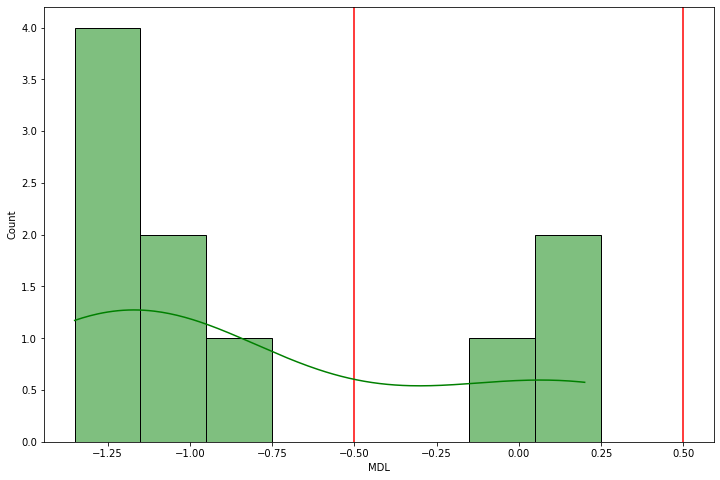

In [245]:
fig = plt.figure(figsize=(12,8))

# plt.Axes.vlines([-0.5,0.5], 0, 1, colors='red', label='Lower Limit')
# plt.vlines(-0.5, 0, 5, colors='red', label='Lower Limit')
# plt.Axes.vlines()
plt.axvline(-.5, 0, 1, color='red')  # lower limit reference line
plt.axvline(0.5, 0, 1, color='red')  # upper limit reference line
# plt.Axes.set_ylabel('Count')
# plt.Axes.set_xlabel('MDL')
sns.histplot(data=df['MDL'], binwidth=0.2, kde=True, color='green')
#plt.hist(df['MDL'],color='green', edgecolor='black')


plt.show()

In [25]:
# won't need this but good example of list comprehension for sorting "list x" based on "list y" (x,y)
# zip the two lists.
# create a new, sorted list based on the zip using sorted().
# using a list comprehension extract the first elements of each pair from the sorted, zipped list.

sorted_prod_target_keys = [x for _, x in sorted(zip(prod_target_keys,target_columns))]
print(sorted_prod_target_keys)

['MDL', 'MDA', 'MDB', 'TDL', 'TDA', 'TDB', 'STR']


In [147]:
True*True
True*False

0

In [34]:
ry = np.array([4,5,6])
len(ry)

3

In [ ]:
def compare_vs_spec():
    pass

In [78]:
test_df = (df['MDL'] <= df_ul_specs[1]) & (df['MDL'] >= df_ll_specs[1])
test_df

0    False
1    False
2    False
3    False
4     True
5    False
6     True
7    False
8    False
9     True
Name: MDL, dtype: bool